# Preprocessing

In [55]:
# To import libraries
import os
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from scipy.io import savemat
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from gudhi import bottleneck_distance
from gudhi.wasserstein import wasserstein_distance
from sklearn.manifold import MDS

# To define FPS function
def farthest_point_sampling(distance_matrix, num_total_points, num_required_sample):
    initial_point = np.random.randint(num_total_points)
    sampled_points, distance_from_sample = [initial_point], distance_matrix[initial_point].copy()
    
    for _ in range(num_required_sample - 1):
        farthest_point = np.argmax(distance_from_sample)
        sampled_points.append(farthest_point)
        another_distance_from_sample = distance_matrix[farthest_point]
        for point in range(num_total_points):
            if distance_from_sample[point] > another_distance_from_sample[point]:
                distance_from_sample[point] = another_distance_from_sample[point]
    
    return sampled_points

In [3]:
total_diagrams, total_shapes = [], []

# To read .tri files & .vert files
directory_path = r'C:\Users\leo&grace\w\kaist\TDA\nonrigid3d'

names = [f.split(".")[0] for f in os.listdir(directory_path) if f.endswith('.tri')]
names.sort()
num_files = len(names)

for name in names:
    tri_file_path = os.path.join(directory_path, f'{name}.tri')
    vert_file_path = os.path.join(directory_path, f'{name}.vert')

# To create a weighted graph representation
    coordinates, length = [0], 0
    with open(vert_file_path, 'r') as file:
        for line in file:
            coordinates.append(list(map(float, line.split())))
            length += 1
    
    my_graph, visit = nx.Graph(), {}
    
    with open(tri_file_path, 'r') as file:
        for line in file:
            for pair in itertools.combinations(map(int, line.split()), 2):
                if visit.get(pair, 0): 
                    continue
                else:
                    visit[pair] = 1
                    a, b = pair[0], pair[1]
                    distance = np.linalg.norm(np.subtract(coordinates[a], coordinates[b]))
                    my_graph.add_edge(a, b, weight=distance)

# To compute geodesic distance matrix
    connected = nx.is_connected(my_graph)
    if not connected:
        connected_components = list(nx.connected_components(my_graph))
        max_connected_component = max(connected_components, key=len)
        my_graph = my_graph.subgraph(max_connected_component)
    shortest_path_length = dict(nx.shortest_path_length(my_graph, weight='weight'))
    
    node_list, length = list(my_graph), len(my_graph)
    geodesic_distance_matrix = np.zeros((length, length))
    for i, node_1 in enumerate(node_list):
        for j, node_2 in enumerate(node_list):
            geodesic_distance_matrix[i][j] = shortest_path_length[node_1][node_2]

# To subsample 200 points via FPS & to reduce the distance matrix
    if connected:
        our_sample = farthest_point_sampling(geodesic_distance_matrix, length, 200)
    else:
        our_sample = farthest_point_sampling(geodesic_distance_matrix, length, min(200, length))
    reduced_distance_matrix = []
    
    for _ in our_sample:
        reduced_distance_matrix.append([geodesic_distance_matrix[_][j] for j in our_sample])

# Compute the Vietoris-Rips persistence diagrams in dimensions 0, 1, and 2
    diagram = ripser(np.array(reduced_distance_matrix), maxdim=2, distance_matrix=True)['dgms']
    total_diagrams.append(diagram)

# To create "shape"
    shape = {'name': name, 'dm': reduced_distance_matrix}
    total_shapes.append(shape)

# To save results
    save_directory = r'C:\Users\leo&grace\w\kaist\TDA\processed_geodesic'
    
    mat_file_path = os.path.join(save_directory, f"pre_geodesic_{name}.mat")
    savemat(mat_file_path, shape)

In [41]:
# group information
group_label = ['cat', 'centaur', 'david', 'dog', 'gorilla', 'horse', 'lioness', 'michael', 'seahorse', 'shark', 'victoria', 'wolf']
groups, checkpoint = {}, 0
for obj in group_label:
    groups[obj] = []
    for idx in range(checkpoint, num_files):
        if total_shapes[idx]['name'].startswith(obj):
            groups[obj].append(idx)
        else:
            checkpoint = idx
            break

# Matrix: dDiam

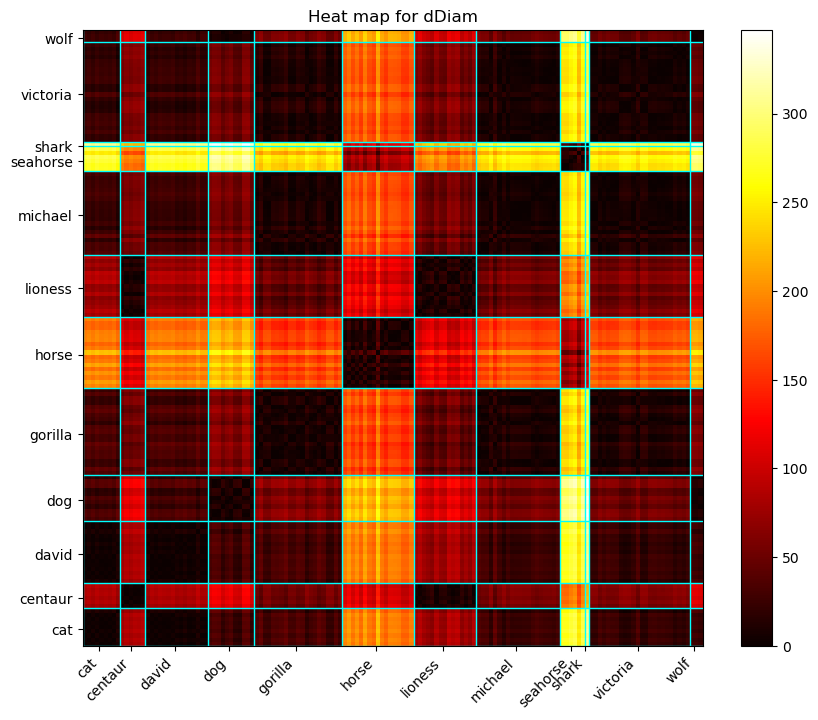

In [42]:
# To compute dDiam matrix
dDiam_matrix = np.zeros((num_files, num_files))

for i in range(num_files):
    for j in range(num_files):
        if j < i:
            dDiam_matrix[i][j] = dDiam_matrix[j][i]
        else:
            dDiam_matrix[i][j] = abs(np.max(total_shapes[i]['dm']) - np.max(total_shapes[j]['dm']))

# To save the result
np.savetxt(r'C:\Users\leo&grace\w\kaist\TDA\dDiam_geodesic.csv', dDiam_matrix, delimiter=',')

# To draw a image: heat map
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolormesh(dDiam_matrix, cmap='hot')

ax.set_xticks([np.median(groups[group]) for group in group_label])
ax.set_yticks([np.median(groups[group]) for group in group_label])

ax.set_xticklabels(group_label, rotation=45, ha='right')
ax.set_yticklabels(group_label)

for group_name, group_indices in groups.items():
    ax.axhline(min(group_indices), color='cyan', linewidth=1)
    ax.axvline(min(group_indices), color='cyan', linewidth=1)
    
cbar = plt.colorbar(heatmap)

plt.savefig('heatmap_geodesic_dDiam.png')
plt.title("Heat map for dDiam")
plt.show()

# To compute distance Matrix & to draw Heatmaps

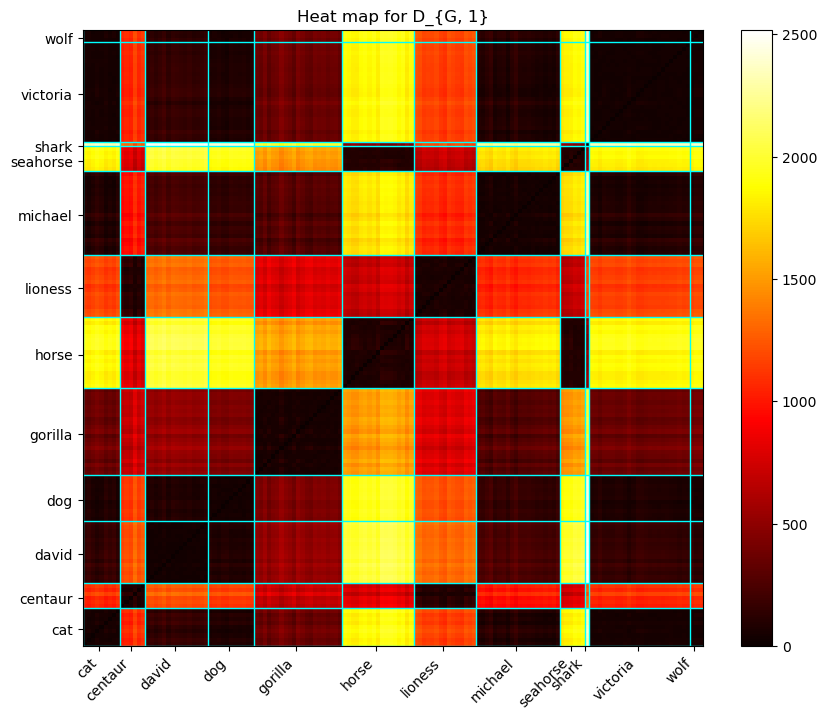

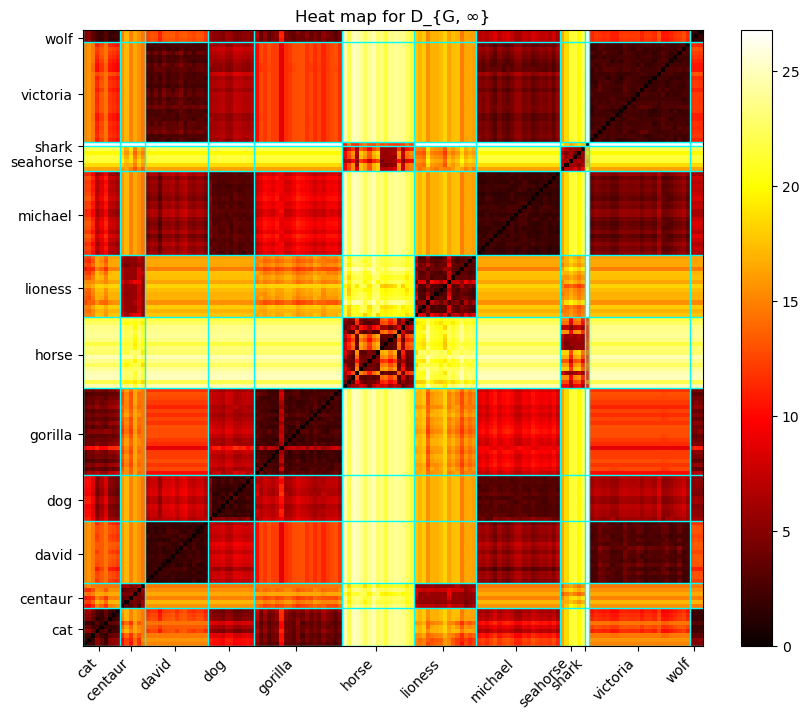

In [51]:
# To compute the wasserstein distance matrix when q = 1
one_wasserstein_distance_matrix = np.zeros((num_files, num_files))

for i in range(num_files):
    for j in range(num_files):
        if j < i:
            one_wasserstein_distance_matrix[i][j] = one_wasserstein_distance_matrix[j][i]
        else:
            one_wasserstein_distance_matrix[i][j] = max([wasserstein_distance(total_diagrams[i][_], total_diagrams[j][_]) for _ in range(3)])

# To compute the wasserstein distance matrix when q = \infty
infty_wasserstein_distance_matrix = np.zeros((num_files, num_files))
for i in range(num_files):
    for j in range(num_files):
        if j < i:
            infty_wasserstein_distance_matrix[i][j] = infty_wasserstein_distance_matrix[j][i]
        elif j == i:
            infty_wasserstein_distance_matrix[i][j] = 0
        else:
            infty_wasserstein_distance_matrix[i][j] = max([bottleneck_distance(total_diagrams[i][_], total_diagrams[j][_]) for _ in range(3)])

# To save the result
np.savetxt(r'C:\Users\leo&grace\w\kaist\TDA\geodesic_wasserstein.csv', one_wasserstein_distance_matrix, delimiter=',')
np.savetxt(r'C:\Users\leo&grace\w\kaist\TDA\geodesic_bottleneck.csv', infty_wasserstein_distance_matrix, delimiter=',')

# To draw heat map: wasserstein
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolormesh(one_wasserstein_distance_matrix, cmap='hot')

ax.set_xticks([np.median(groups[group]) for group in group_label])
ax.set_yticks([np.median(groups[group]) for group in group_label])

ax.set_xticklabels(group_label, rotation=45, ha='right')
ax.set_yticklabels(group_label)

for group_name, group_indices in groups.items():
    ax.axhline(min(group_indices), color='cyan', linewidth=1)
    ax.axvline(min(group_indices), color='cyan', linewidth=1)
    
cbar = plt.colorbar(heatmap)

plt.savefig('heatmap_geodesic_wasserstein.png')
plt.title("Heat map for D_{G, 1}")
plt.show()

# To draw heat map: bottleneck
fig, ax = plt.subplots(figsize=(10, 8))
heatmap = ax.pcolormesh(infty_wasserstein_distance_matrix, cmap='hot')

ax.set_xticks([np.median(groups[group]) for group in group_label])
ax.set_yticks([np.median(groups[group]) for group in group_label])

ax.set_xticklabels(group_label, rotation=45, ha='right')
ax.set_yticklabels(group_label)

for group_name, group_indices in groups.items():
    ax.axhline(min(group_indices), color='cyan', linewidth=1)
    ax.axvline(min(group_indices), color='cyan', linewidth=1)
    
cbar = plt.colorbar(heatmap)

plt.savefig('heatmap_geodesic_bottleneck.png')
plt.title("Heat map for D_{G, ∞}")
plt.show()

# To draw dendrograms

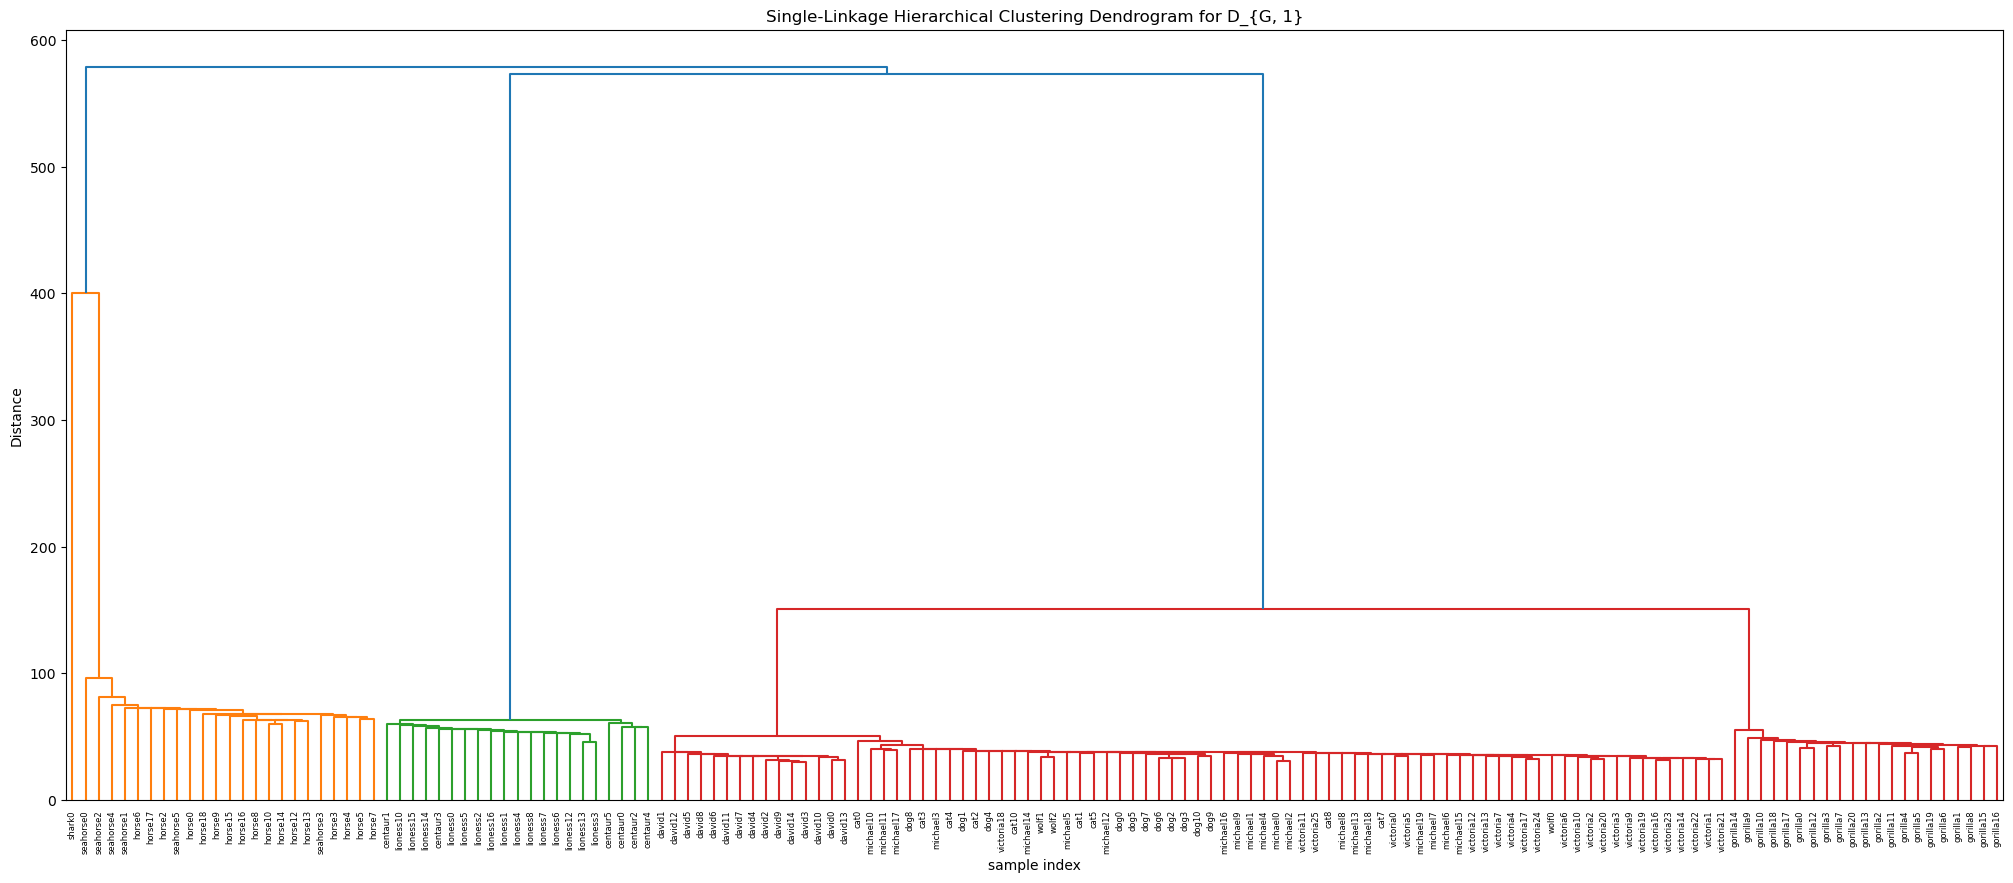

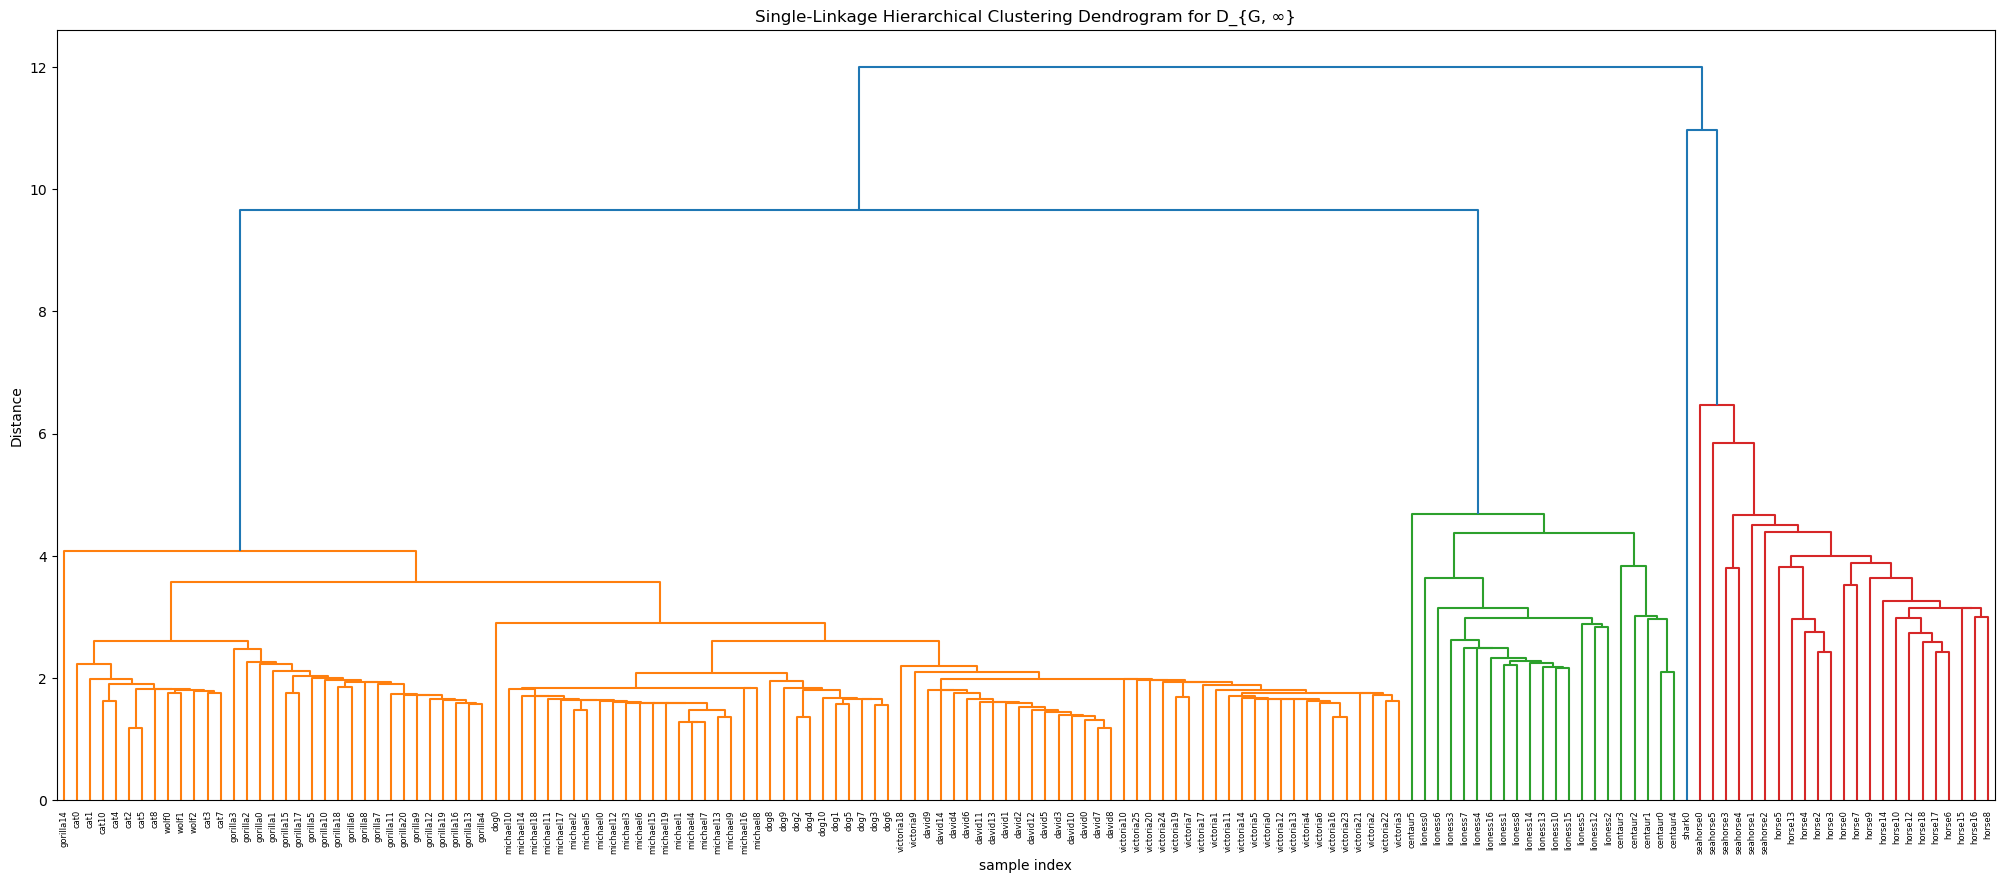

In [85]:
# To draw dendrogram: wasserstein
linkage_matrix_wasserstein = linkage(squareform(one_wasserstein_distance_matrix))


plt.figure(figsize=(25, 10))
plt.title('Single-Linkage Hierarchical Clustering Dendrogram for D_{G, 1}')
plt.xlabel('sample index')
plt.ylabel('Distance')

dendrogram(linkage_matrix_wasserstein, leaf_label_func=lambda x: total_shapes[x]['name'], leaf_rotation=90., leaf_font_size=6.)

plt.savefig('Dendrogram_geodesic_wasserstein')
plt.show()

# To draw dendrogram: bottleneck
linkage_matrix_bottleneck = linkage(squareform(infty_wasserstein_distance_matrix))

plt.figure(figsize=(25, 10))
plt.title('Single-Linkage Hierarchical Clustering Dendrogram for D_{G, ∞}')
plt.xlabel('sample index')
plt.ylabel('Distance')

dendrogram(linkage_matrix_bottleneck, leaf_label_func=lambda x: total_shapes[x]['name'], leaf_rotation=90., leaf_font_size=6.)

plt.savefig('Dendrogram_geodesic_bottleneck')
plt.show()

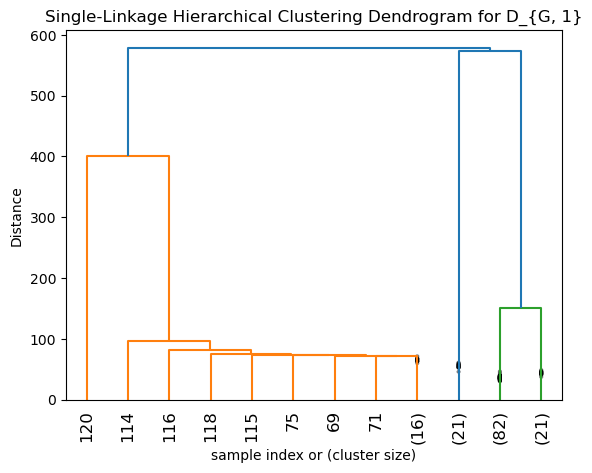

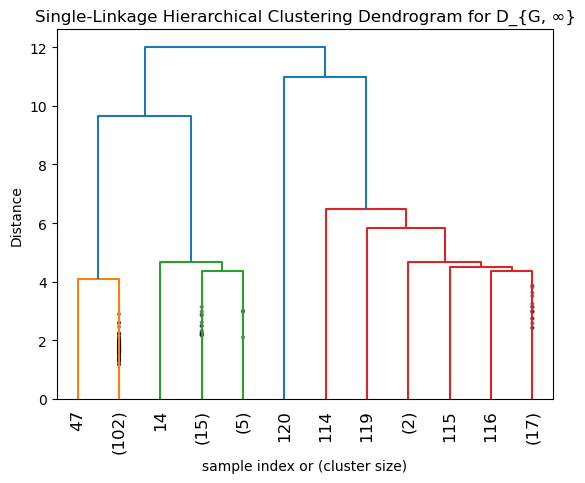

In [75]:
# To draw truncated dendrogram: wasserstein
linkage_matrix_wasserstein = linkage(squareform(one_wasserstein_distance_matrix))

dendrogram(linkage_matrix_wasserstein, truncate_mode='lastp', p=12, show_leaf_counts=True,
    leaf_rotation=90., leaf_font_size=12., show_contracted=True)

plt.title('Single-Linkage Hierarchical Clustering Dendrogram for D_{G, 1}')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

# To draw truncated dendrogram: bottleneck
linkage_matrix_bottleneck = linkage(squareform(infty_wasserstein_distance_matrix))

dendrogram(linkage_matrix_bottleneck, truncate_mode='lastp', p=12, show_leaf_counts=True,
    leaf_rotation=90., leaf_font_size=12., show_contracted=True)

plt.title('Single-Linkage Hierarchical Clustering Dendrogram for D_{G, ∞}')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()

# To draw MDS plots

C:\Users\Public\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


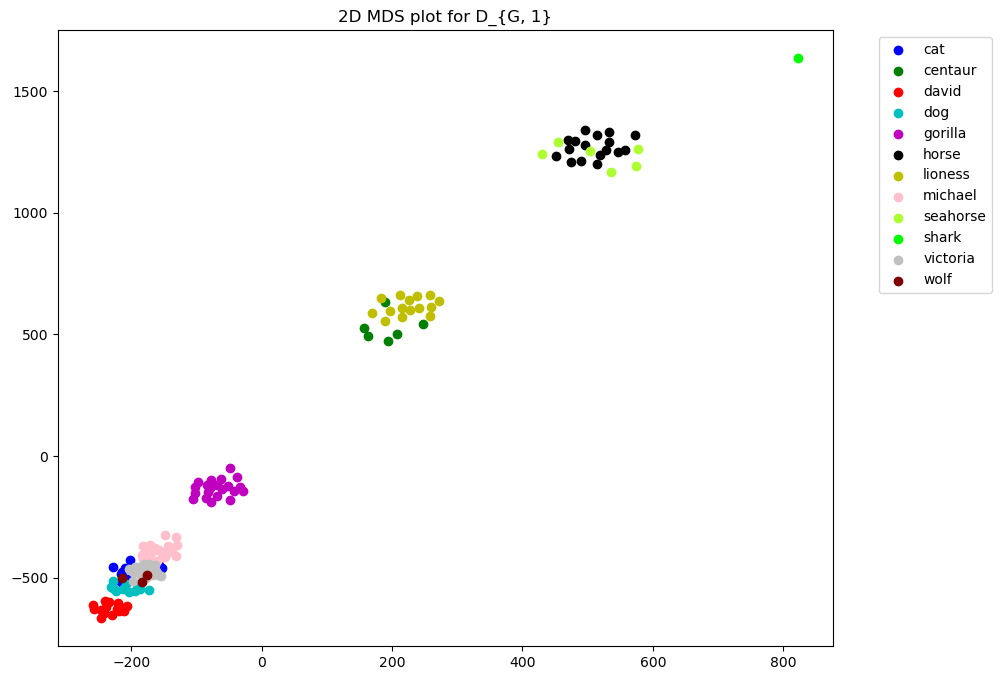

C:\Users\Public\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


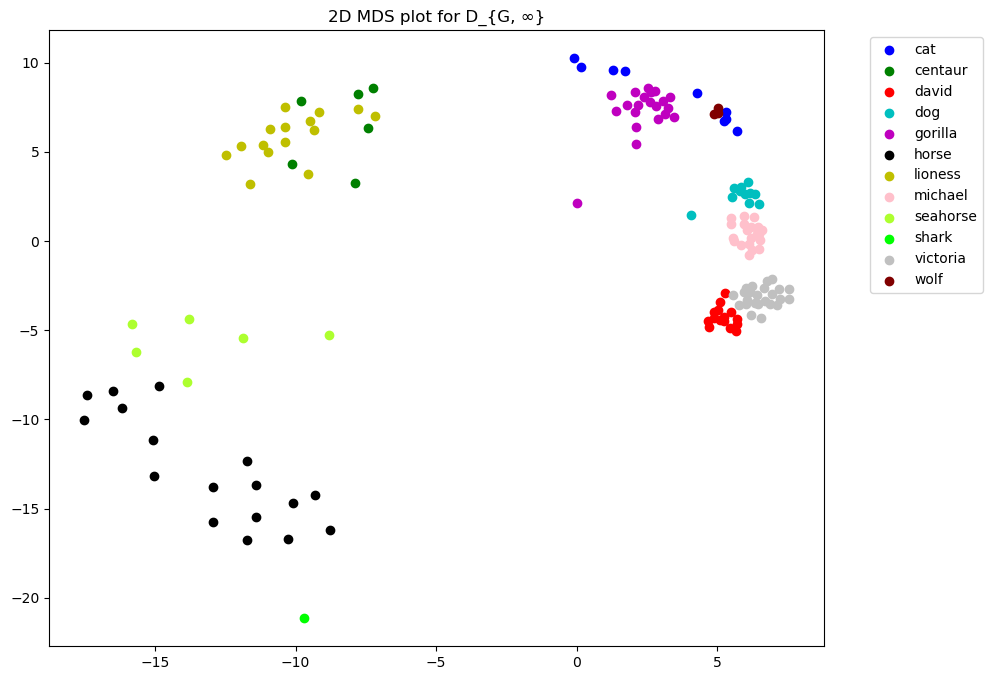

In [59]:
label_color = {'cat': 'b', 'centaur': 'g', 'david': 'r', 'dog': 'c', 'gorilla': 'm', 'horse': 'k', 'lioness': 'y', 
               'michael': 'pink', 'seahorse': 'greenyellow', 'shark': 'lime', 'victoria': 'silver', 'wolf': 'maroon'}

# To draw 2-dimensional MDS plot: wasserstein
embedding_wasserstein = MDS(dissimilarity='precomputed')
transformed = embedding_wasserstein.fit_transform(one_wasserstein_distance_matrix)

fig, ax = plt.subplots(figsize=(10, 8))

for label, color in label_color.items():
    x_data = [transformed[:, 0][i] for i in groups[label]]
    y_data = [transformed[:, 1][j] for j in groups[label]]
    ax.scatter(x_data, y_data, c=color, label=label)

ax.set_title('2D MDS plot for D_{G, 1}')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('MDS_geodesic_wasserstein', bbox_inches='tight')
plt.show()

# To draw 2-dimensional MDS plot: bottleneck
embedding_bottleneck = MDS(dissimilarity='precomputed')
transformed = embedding_bottleneck.fit_transform(infty_wasserstein_distance_matrix)

fig, ax = plt.subplots(figsize=(10, 8))

for label, color in label_color.items():
    x_data = [transformed[:, 0][i] for i in groups[label]]
    y_data = [transformed[:, 1][j] for j in groups[label]]
    ax.scatter(x_data, y_data, c=color, label=label)

ax.set_title('2D MDS plot for D_{G, ∞}')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig('MDS_geodesic_bottleneck', bbox_inches='tight')
plt.show()